In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import timedelta

# Load the data
data = pd.read_csv('data/btcdata.csv', parse_dates=['Date'])

# If 'Price' column is already numeric or has NaNs, we don't need to convert it
# If it contains commas, we'll handle it during the reading process
data['Price'] = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce')

# Remove any rows where 'Price' could not be converted to numeric
data = data.dropna(subset=['Price'])

# Sort data by date just to make sure
data = data.sort_values('Date')

# Now proceed with normalization, sequence creation, etc.
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(data['Price'].values.reshape(-1, 1))


# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Using 30 days for prediction
X, y = create_sequences(price_scaled, sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

In [47]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).requires_grad_()
        
        output, (hn, cn) = self.lstm(input_seq, (h0.detach(), c0.detach()))
        output = self.linear(output[:, -1, :]) 
        return output

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs} Loss: {single_loss.item()}')

Epoch 0/100 Loss: 0.008135109208524227
Epoch 10/100 Loss: 0.0006658397032879293
Epoch 20/100 Loss: 0.001457689213566482
Epoch 30/100 Loss: 0.0005709573160856962
Epoch 40/100 Loss: 0.0006896308623254299
Epoch 50/100 Loss: 0.0004993743496015668
Epoch 60/100 Loss: 0.0003962689370382577
Epoch 70/100 Loss: 0.0004896100144833326
Epoch 80/100 Loss: 0.00023658103600610048
Epoch 90/100 Loss: 0.0005616602138616145


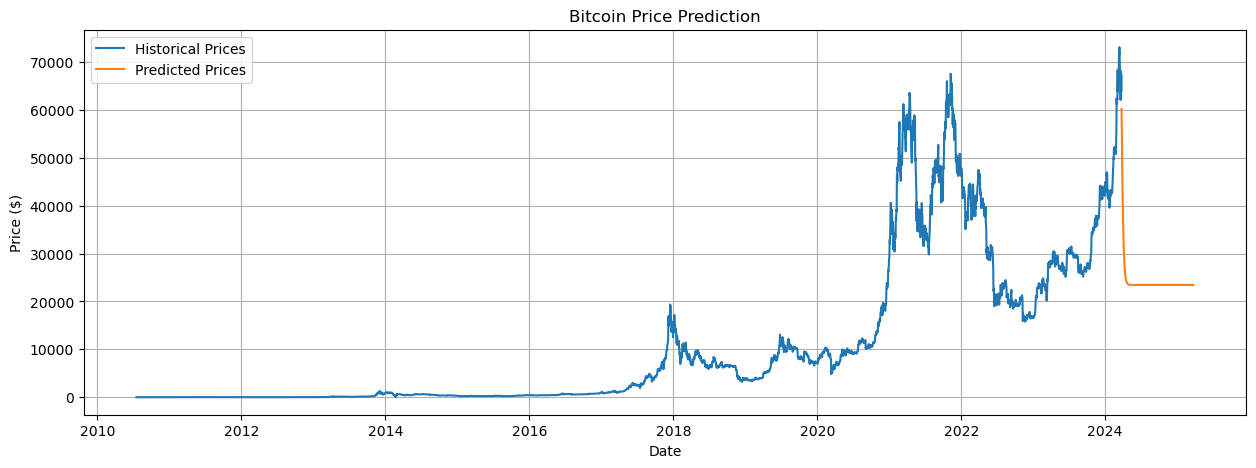

In [48]:
def predict_next_year_with_dates(model, last_sequence, last_date, n_days=365):
    model.eval()
    predictions = []
    sequence = last_sequence.copy()
    current_date = last_date
    
    for _ in range(n_days):
        seq_tensor = torch.FloatTensor(sequence).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            y_pred = model(seq_tensor)
        
        predicted_price = y_pred[0].item()
        predictions.append(predicted_price)
        
        # Shift the sequence and add the new prediction
        sequence = np.roll(sequence, -1)
        sequence[-1] = predicted_price  # This should be a scalar
    
        # Update the date for the next prediction
        current_date += timedelta(days=1)
    
    return predictions, pd.date_range(start=last_date, periods=n_days, freq='D')

last_sequence = X[-1]
last_date = data['Date'].iloc[-1]

future_prices_scaled, future_dates = predict_next_year_with_dates(model, last_sequence, last_date)
future_prices = scaler.inverse_transform(np.array(future_prices_scaled).reshape(-1, 1))

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(data['Date'], data['Price'], label='Historical Prices')
plt.plot(future_dates, future_prices, label='Predicted Prices')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()